In [6]:
#importing important libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from skmultilearn.model_selection import iterative_train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss,f1_score,confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

from sklearn.preprocessing import LabelEncoder

In [7]:
#reading train dataset

train_features=pd.read_csv('train_features.csv')
test_features=pd.read_csv('test_features.csv')
train_targets_scored=pd.read_csv('train_targets_scored.csv')
train_targets_nonscored=pd.read_csv('lish-moa/train_targets_nonscored.csv')

In [8]:
#list of names of the MoAs in the dataset
target_cols_scored=[col for col in train_targets_scored.columns if col not in ['sig_id']]
target_cols_nonscored=[col for col in train_targets_nonscored.columns if col not in ['sig_id']]

In [9]:
#separating gene feautres and cell features in a separate list
#we know that all the gene expression features name starts with 'g-' and cell features name starts with 'c-', hence trying to observe set of all the gene expression as one function and all the cell functions as one features
gene_features=[]
cell_features=[]
for i in train_features.columns:
    if i.startswith('g-'):
        gene_features.append(i)
    if i.startswith('c-'):
        cell_features.append(i)

In [10]:
print(len(gene_features))
print(len(cell_features))

772
100


In [11]:
#merging the train dataset and train target scored dataset into one
train_merge=pd.merge(train_features,train_targets_scored,on="sig_id",how="left")

In [12]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(train_merge['cp_type'])
train_merge['cp_type_le']=le.transform(train_merge['cp_type'])
test_features['cp_type_le']=le.transform(test_features['cp_type'])

In [13]:
le1=LabelEncoder()
le1.fit(train_merge['cp_time'])
train_merge['cp_time_le']=le1.transform(train_merge['cp_time'])
test_features['cp_time_le']=le1.transform(test_features['cp_time'])

In [14]:
le2=LabelEncoder()
le2.fit(train_merge['cp_dose'])
train_merge['cp_dose_le']=le2.transform(train_merge['cp_dose'])
test_features['cp_dose_le']=le2.transform(test_features['cp_dose'])

In [15]:
removals=[]
removals.append('cp_dose')
removals.append('cp_type')
removals.append('cp_time')
#removals.append('sig_id')
#removals.append('MoA_present')

In [17]:
X=train_merge.drop(columns=[i for i in removals])
#Y=train_merge['MoA_present']

In [19]:
X.head()

,sig_id,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,cp_type_le,cp_time_le,cp_dose_le
0,id_000644bb2,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,...,0,0,0,0,0,0,0,1,0,0
1,id_000779bfc,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,...,0,0,0,0,0,0,0,1,2,0
2,id_000a6266a,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,...,0,0,0,0,0,0,0,1,1,0
3,id_0015fd391,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,...,0,0,0,0,0,0,0,1,1,0
4,id_001626bd3,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,...,0,0,0,0,0,0,0,1,2,1


In [21]:
X.shape,test_features.shape

((23814, 1082), (3982, 879))

In [22]:
Y=X[target_cols_scored]

In [23]:
Y.shape

(23814, 206)

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Input, BatchNormalization


<h2>Gene_Features</h2>

In [25]:
X[gene_features].shape

(23814, 772)

In [27]:
#Encoder part
inp=Input(shape=(772,))

enc1=Dense(512,activation='relu')(inp)
bn=BatchNormalization()(enc1)
enc2=Dense(420,activation='relu')(bn)
#decoder part
dec1=Dense(420,activation='relu')(enc2)
bn=BatchNormalization()(dec1)
dec2=Dense(512,activation='relu')(bn)
bn=BatchNormalization()(dec2)
dec3=Dense(772)(enc2)

model=tf.keras.Model(inputs=inp,outputs=dec3)


model.compile(optimizer='adam', loss='mse')


In [29]:
model.fit(X[gene_features],X[gene_features],batch_size=1000,epochs=200)

Epoch 1/200
24/24 [==============================] - 1s 59ms/step - loss: 0.5092
Epoch 2/200
24/24 [==============================] - 1s 59ms/step - loss: 0.4754
Epoch 3/200
24/24 [==============================] - 1s 59ms/step - loss: 0.4481
Epoch 4/200
24/24 [==============================] - 1s 59ms/step - loss: 0.4228
Epoch 5/200
24/24 [==============================] - 1s 58ms/step - loss: 0.3910
Epoch 6/200
24/24 [==============================] - 1s 58ms/step - loss: 0.3648
Epoch 7/200
24/24 [==============================] - 1s 59ms/step - loss: 0.3453
Epoch 8/200
24/24 [==============================] - 1s 58ms/step - loss: 0.3225
Epoch 9/200
24/24 [==============================] - 1s 59ms/step - loss: 0.3058
Epoch 10/200
24/24 [==============================] - 1s 57ms/step - loss: 0.2876
Epoch 11/200
24/24 [==============================] - 1s 58ms/step - loss: 0.2759
Epoch 12/200
24/24 [==============================] - 1s 57ms/step - loss: 0.2583
Epoch 13/200
24/24 [=====

In [31]:
#Note we need to just take the output of the encoded part as it has the summarizes all the 772 gene features
encoder =tf.keras. Model(inputs=inp, outputs=enc2)
#save the encoder to a file
encoder.save('encoder1.h5')

<h2> Cell_Features</h2>

In [33]:
X[cell_features].shape

(23814, 100)

In [35]:
#Encoder part
inp=Input(shape=(100,))

enc1=Dense(90,activation='relu')(inp)
bn=BatchNormalization()(enc1)
enc2=Dense(75,activation='relu')(bn)
#decoder part
dec1=Dense(75,activation='relu')(enc2)
bn=BatchNormalization()(dec1)
dec2=Dense(90,activation='relu')(bn)
bn=BatchNormalization()(dec2)
dec3=Dense(100)(enc2)

model=tf.keras.Model(inputs=inp,outputs=dec3)


model.compile(optimizer='adam', loss='mse')

In [36]:
model.fit(X[cell_features],X[cell_features],batch_size=1000,epochs=200)

Epoch 1/200
24/24 [==============================] - 1s 7ms/step - loss: 3.4944
Epoch 2/200
24/24 [==============================] - 0s 7ms/step - loss: 0.9449
Epoch 3/200
24/24 [==============================] - 0s 8ms/step - loss: 0.5822
Epoch 4/200
24/24 [==============================] - 0s 8ms/step - loss: 0.5367
Epoch 5/200
24/24 [==============================] - 0s 8ms/step - loss: 0.5156
Epoch 6/200
24/24 [==============================] - 0s 8ms/step - loss: 0.4988
Epoch 7/200
24/24 [==============================] - 0s 8ms/step - loss: 0.4817
Epoch 8/200
24/24 [==============================] - 0s 8ms/step - loss: 0.4551
Epoch 9/200
24/24 [==============================] - 0s 8ms/step - loss: 0.4419
Epoch 10/200
24/24 [==============================] - 0s 8ms/step - loss: 0.4339
Epoch 11/200
24/24 [==============================] - 0s 8ms/step - loss: 0.4195
Epoch 12/200
24/24 [==============================] - 0s 8ms/step - loss: 0.4080
Epoch 13/200
24/24 [=================

In [37]:
encoder =tf.keras. Model(inputs=inp, outputs=enc2)
#save the encoder to a file
encoder.save('encoder_cell_features1.h5')

In [39]:
encoder = load_model('encoder1.h5')
X1_train_gene_features=encoder.predict(X[gene_features])
X_test_gene_features=encoder.predict(test_features[gene_features])

encoder = load_model('encoder_cell_features1.h5')
X1_train_cell_features=encoder.predict(X[cell_features])
X_test_cell_features=encoder.predict(test_features[cell_features])

In [40]:
X2_train=np.hstack((X1_train_gene_features,X1_train_cell_features,X['cp_type_le'].values.reshape(-1,1),X['cp_time_le'].values.reshape(-1,1),X['cp_dose_le'].values.reshape(-1,1)))

In [41]:
X2_test=np.hstack((X_test_gene_features,X_test_cell_features,test_features['cp_type_le'].values.reshape(-1,1),test_features['cp_time_le'].values.reshape(-1,1),test_features['cp_dose_le'].values.reshape(-1,1)))

In [42]:
X.head()

,sig_id,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,cp_type_le,cp_time_le,cp_dose_le
0,id_000644bb2,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,...,0,0,0,0,0,0,0,1,0,0
1,id_000779bfc,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,...,0,0,0,0,0,0,0,1,2,0
2,id_000a6266a,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,...,0,0,0,0,0,0,0,1,1,0
3,id_0015fd391,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,...,0,0,0,0,0,0,0,1,1,0
4,id_001626bd3,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,...,0,0,0,0,0,0,0,1,2,1


In [46]:
X2_train.shape,Y.shape

((23814, 498), (23814, 206))

In [44]:
from skmultilearn.problem_transform import ClassifierChain

In [47]:
classifier = ClassifierChain(classifier = RandomForestClassifier(max_depth=7,n_estimators=75))
classifier.fit(X2_train,Y)


ClassifierChain(classifier=RandomForestClassifier(max_depth=7, n_estimators=75),
                require_dense=[True, True])

In [48]:
prediction=classifier.predict_proba(X2_test)

In [49]:
prediction.shape

(3982, 206)

In [51]:
submission=pd.DataFrame(prediction.todense(),columns=[i for i in target_cols_scored])

In [52]:
submission['sig_id']=test_features['sig_id']

In [53]:
submission.shape

(3982, 207)

In [54]:
submission.to_csv("submission.csv",index=False)

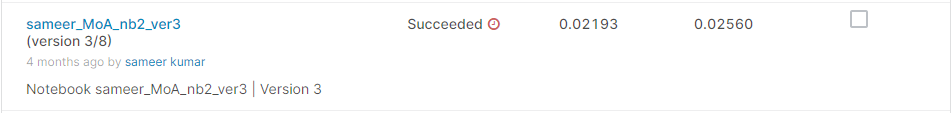
